In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import pandas as pd
import requests
import json

In [7]:
dg = pd.read_csv('casa_postalcode.csv',delimiter=';')
dg= dg.rename(columns={'QUARTIER':'neighborhood','CODE POSTAL':'postal_code'})
dg

,neighborhood,postal_code
0,FLORIDA IMB,20270
1,FLORIDA VILLA,20270
2,ADDAMANE,20460
3,ADMINISTRATIF,20220
4,AGENCE URBAINE,20260
...,...,...
371,ZONE INDUSTRIELLE,20280
372,ZONE INDUSTRIELLE,20270
373,ZONE INDUSTRIELLE,20190
374,ZONE INDUSTRIELLE OUKACHA,20580


In [10]:
#using tomtom geocoding api

In [11]:

dg['latitude'] = None
dg['longitude'] = None

api_endpoint = "https://api.tomtom.com/search/2/geocode/{}.json?key={}"
api_key = "1MkfAzNBj7I2Dzc8ykU8GZ0trxhxXaAW" 

for i, row in dg.iterrows():
    query = "{},{},casablanca,Grand Casablanca, Maroc".format( row['neighborhood'], row['postal_code'])
    response = requests.get(api_endpoint.format(query, api_key))
    print(response)
    if response.status_code == 200:
        try:
            data = response.json()
            if 'results' in data and len(data['results']) > 0:
                dg.at[i, 'latitude'] = data['results'][0]['position']['lat']
                dg.at[i, 'longitude'] = data['results'][0]['position']['lon']
            else:
                print(f"No results found for address {query}")
        except json.JSONDecodeError:
            print(f"An error occured while parsing the json response for {query}")
    elif response.status_code == 429:
        time_to_wait = response.headers.get('x-ratelimit-interval')
        if time_to_wait:
            time_to_wait = int(time_to_wait)
        print(f"You exceeded the limit of requests, you have to wait {time_to_wait} seconds before making a new request")
    else:
        print(f"An error occured with the request for {query}, status code: {response.status_code}")

dg.to_csv('geocoded_addresses_tomtom.csv')

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

In [12]:
dh=pd.read_csv("geocoded_addresses_tomtom.csv")
dh

,Unnamed: 0,neighborhood,postal_code,latitude,longitude
0,0,FLORIDA IMB,20270,33.51861,-7.64969
1,1,FLORIDA VILLA,20270,33.56222,-7.63232
2,2,ADDAMANE,20460,33.53180,-7.61389
3,3,ADMINISTRATIF,20220,33.55698,-7.67782
4,4,AGENCE URBAINE,20260,33.53651,-7.69520
...,...,...,...,...,...
371,371,ZONE INDUSTRIELLE,20280,33.50828,-7.66245
372,372,ZONE INDUSTRIELLE,20270,33.52465,-7.65353
373,373,ZONE INDUSTRIELLE,20190,33.52567,-7.67459
374,374,ZONE INDUSTRIELLE OUKACHA,20580,33.62833,-7.50674


In [13]:
dh=dh.dropna()
dh

,Unnamed: 0,neighborhood,postal_code,latitude,longitude
0,0,FLORIDA IMB,20270,33.51861,-7.64969
1,1,FLORIDA VILLA,20270,33.56222,-7.63232
2,2,ADDAMANE,20460,33.53180,-7.61389
3,3,ADMINISTRATIF,20220,33.55698,-7.67782
4,4,AGENCE URBAINE,20260,33.53651,-7.69520
...,...,...,...,...,...
371,371,ZONE INDUSTRIELLE,20280,33.50828,-7.66245
372,372,ZONE INDUSTRIELLE,20270,33.52465,-7.65353
373,373,ZONE INDUSTRIELLE,20190,33.52567,-7.67459
374,374,ZONE INDUSTRIELLE OUKACHA,20580,33.62833,-7.50674


In [14]:
# configure the place, network type, trip times, and travel speed
place = {"city": "casablanca"}
network_type = "walk"

In [15]:
# download the street network
G = ox.graph_from_place(place, network_type=network_type)

In [16]:
# define the max_distance for the POI search
max_distance = 400 # 400 m, about 15 minutes walking distance

# download the street network
G = ox.graph_from_place(place, network_type=network_type)

# list to store the results
pois_data = []

# iterate over the locations in the dataframe
for index, row in dh.iterrows():
    node = ox.nearest_nodes(G, row.latitude, row.longitude)
    # extract the POI data within max_distance of the node
    pois = ox.geometries.geometries_from_point((row.latitude, row.longitude),tags={'amenity': True}, dist=max_distance)
    pois_df = pois.assign(neighborhood=row['neighborhood'], postal_code=row['postal_code'])
    pois_data.append(pois_df)
    pois_data.append(pois)
# concatenate all poi
pois_df = pd.concat(pois_data)

In [17]:
grouped_pois = pois_df.groupby(['neighborhood','postal_code'])
# count the number of POIs in each neighborhood
poi_counts = grouped_pois.size().reset_index(name='poi_count')
poi_counts

,neighborhood,postal_code,poi_count
0,ADDAMANE,20460.0,10
1,ADMINISTRATIF,20220.0,31
2,AGENCE URBAINE,20260.0,4
3,AHL LOGHLAM,20620.0,12
4,AHL LOGHLAM,20640.0,12
...,...,...,...
348,ZINEB,20260.0,4
349,ZONE INDUSTRIELLE,20190.0,1
350,ZONE INDUSTRIELLE,20270.0,16
351,ZONE INDUSTRIELLE,20280.0,3


In [18]:
poi_counts.to_csv('poi_counts.csv')

In [23]:
poi_counts=pd.read_csv('poi_counts.csv',delimiter=',')

In [24]:
poi_counts= poi_counts.reset_index()
poi_counts

,index,Unnamed: 0,neighborhood,postal_code,poi_count
0,0,0,ADDAMANE,20460.0,10
1,1,1,ADMINISTRATIF,20220.0,31
2,2,2,AGENCE URBAINE,20260.0,4
3,3,3,AHL LOGHLAM,20620.0,12
4,4,4,AHL LOGHLAM,20640.0,12
...,...,...,...,...,...
348,348,348,ZINEB,20260.0,4
349,349,349,ZONE INDUSTRIELLE,20190.0,1
350,350,350,ZONE INDUSTRIELLE,20270.0,16
351,351,351,ZONE INDUSTRIELLE,20280.0,3


In [25]:
poi_counts = poi_counts.sort_values(by='poi_count')
poi_counts

,index,Unnamed: 0,neighborhood,postal_code,poi_count
312,312,312,SIDI ABDELLAH BEN LHAJ,20580.0,1
221,221,221,LAYMOUNE,20190.0,1
297,297,297,RÉSIDANCE ANSSAE,20520.0,1
333,333,333,TASSAHOUL,20160.0,1
228,228,228,LOT CHEFCHAOUINI,20590.0,1
...,...,...,...,...,...
12,12,12,AL BAIDA,20370.0,148
107,107,107,DERB KHLID,20440.0,148
137,137,137,FERARA,20240.0,148
326,326,326,SMARA,20240.0,148


In [69]:
poi_counts.tail(10)

,index,Unnamed: 0,neighborhood,postal_code,poi_count
126,126,126,EDDOUHA AL FAAL,20250.0,148
67,67,67,BOURGOGNE,20050.0,148
14,14,14,AL FIRDOUS,20220.0,148
13,13,13,AL BAIDA,20610.0,148
192,192,192,IDÉAL,20050.0,148
12,12,12,AL BAIDA,20370.0,148
107,107,107,DERB KHLID,20440.0,148
137,137,137,FERARA,20240.0,148
326,326,326,SMARA,20240.0,148
298,298,298,RÉSIDANCE CHARAF TAROUDANTE,20640.0,156


In [70]:
poi_counts.head(10)

,index,Unnamed: 0,neighborhood,postal_code,poi_count
312,312,312,SIDI ABDELLAH BEN LHAJ,20580.0,1
221,221,221,LAYMOUNE,20190.0,1
297,297,297,RÉSIDANCE ANSSAE,20520.0,1
333,333,333,TASSAHOUL,20160.0,1
228,228,228,LOT CHEFCHAOUINI,20590.0,1
217,217,217,LAHJAJMA,20160.0,1
343,343,343,Z.I AIN SEBAA,20590.0,1
130,130,130,EL MANAR,20160.0,1
120,120,120,DIYAR,20160.0,1
269,269,269,NASSIM,20190.0,1


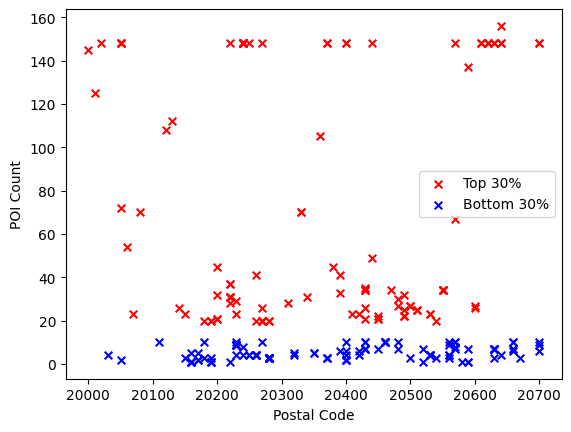

In [39]:
import matplotlib.pyplot as plt
import pandas as pd


# Calculate the threshold for top and bottom 30%
n_neighborhoods = poi_counts.shape[0]
top_threshold = poi_counts['poi_count'].nlargest(n_neighborhoods//3).min()
bottom_threshold = poi_counts['poi_count'].nsmallest(n_neighborhoods//3).max()

# Select the neighborhoods with top 30% POI counts
top_poi_counts = poi_counts[poi_counts['poi_count'] >= top_threshold]

# Select the neighborhoods with bottom 30% POI counts
bottom_poi_counts = poi_counts[poi_counts['poi_count'] <= bottom_threshold]

# Plot the scatter plot for top neighborhoods
plt.scatter(x=top_poi_counts['postal_code'], y=top_poi_counts['poi_count'], color='red', label='Top 30%',marker='x', s=30)

# Plot the scatter plot for bottom neighborhoods
plt.scatter(x=bottom_poi_counts['postal_code'], y=bottom_poi_counts['poi_count'], color='blue', label='Bottom 30%', marker='x', s=30)

# Label the x and y axes
plt.xlabel('Postal Code')
plt.ylabel('POI Count')

# Add legend
plt.legend()

# Show the plot
plt.show()
